# DNS LOAN PREDICTION CHALLENGE

## 1.0 Description of the challenge:

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:.
- 1) willingness to pay and 
- 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

It is your job to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.

### 1.1 Problem

This competition is a supervised classification machine learning task. The objective is to use historical financial and socioeconomic data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

### 1.2 Description of the data

There are 3 different datasets for both train and test

#### 1.2.1 Demographic data (traindemographics.csv)
- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)

#### 1.2.2 Performance data (trainperf.csv) : 
This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict if whether this loan would default given all previous loans and demographics of a customer.
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
- referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predic

#### 1.2.3 Previous loans data (trainprevloans.csv) : 
This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)

### 1.3 Setting up the environment

**Python Libraries**

I have used below list of python packages. Kindly note that there many alternative libraries available for same techniques. 

To install a python library type **"pip install"** or those using the anaconda environment **"conda install"**

In [1]:
import pandas as pd                             #import pandas for dataframe manipulation
import numpy as np                              #import numerical python
import seaborn as sns                           #seaborn for visuals
import matplotlib as mpl                        #matplot for plotting
import matplotlib.pyplot as plt                 #matplot for plotting
import itertools
import datetime as dt                           #convert date formats
from scipy import stats                         #statistical analysis


from IPython.display import display             # Allows the use of display() for DataFrames
import warnings                                 # Suppress warnings 
warnings.filterwarnings('ignore') 
import os                                       # File system manangement
import gc                                       # memory management

In [2]:
#Setting styles and aesthetics
pd.options.display.max_columns =200
pd.options.display.max_rows =30
pd.options.display.float_format = '{:,.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 8)

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

%matplotlib inline

---

## 2. Introduction

### 2.1 Load The Data

In [3]:
#Read datasets
traindemographics = pd.read_csv('../data/raw/traindemographics.csv', parse_dates=['birthdate'])
testdemographics = pd.read_csv('../data/raw/testdemographics.csv', parse_dates=['birthdate'])
trainperf = pd.read_csv('../data/raw/trainperf.csv', parse_dates=['approveddate','creationdate'])
testperf = pd.read_csv('../data/raw/testperf.csv',parse_dates=['approveddate','creationdate'])
trainprevloans= pd.read_csv('../data/raw/trainprevloans.csv', parse_dates=['approveddate','creationdate','closeddate',
                                                                           'firstduedate','firstrepaiddate'])
testprevloans = pd.read_csv('../data/raw/testprevloans.csv', parse_dates=['approveddate','creationdate','closeddate',
                                                                          'firstduedate','firstrepaiddate'])

### 2.2 Data Dimension

In [4]:
# Check The Shape Of The Data Loaded
print('Test Demographic shape: {} Rows, {} Columns'.format(*trainperf.shape))
print('Test Performance shape: {} Rows, {} Columns'.format(*traindemographics.shape))
print('Test Previous Loan shape: {} Rows, {} Columns'.format(*trainprevloans.shape))
print('Train Demographic shape: {} Rows, {} Columns'.format(*testperf.shape))
print('Train Performance shape: {} Rows, {} Columns'.format(*testdemographics.shape))
print('Train Previous Loan shape: {} Rows, {} Columns'.format(*testprevloans.shape))

Test Demographic shape: 4368 Rows, 10 Columns
Test Performance shape: 4346 Rows, 9 Columns
Test Previous Loan shape: 18183 Rows, 12 Columns
Train Demographic shape: 1450 Rows, 9 Columns
Train Performance shape: 1487 Rows, 9 Columns
Train Previous Loan shape: 5907 Rows, 12 Columns


### 2.3 First Few rows of Data

In [5]:
# Print First Few Rows Of The Data
display("test demographics")
display(testdemographics.head(3))
display("test performance")
display(testperf.head(3))
display("test previous loans")
display(testprevloans.head(3))
display("train demographics")
display(traindemographics.head(3))
display("train performance")
display(trainperf.head(3))
display("train previous loans")
display(trainprevloans.head(3))

'test demographics'

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28,Savings,5.30,7.59,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23,Savings,3.29,6.60,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04,Savings,8.50,7.73,First Bank,NaN,Permanent,NaN


'test performance'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,"12,250.00",30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,"44,000.00",30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,"24,500.00",30,NaN


'test previous loans'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00,2016-05-17 09:36:55,"10,000.00","13,000.00",30,2016-06-17 00:04:15,NaN,2016-06-16,2016-06-16 15:44:08
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59,2017-02-04 20:28:52,"30,000.00","36,800.00",60,2017-03-02 16:22:58,NaN,2017-03-06,2017-03-02 16:07:47
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22,2017-03-04 09:28:16,"30,000.00","34,400.00",30,2017-04-02 00:44:24,NaN,2017-04-03,2017-04-01 21:29:46


'train demographics'

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.32,6.53,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.33,7.12,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.75,5.56,Fidelity Bank,NaN,NaN,NaN


'train performance'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,"30,000.00","34,500.00",30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,"15,000.00","17,250.00",30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,"20,000.00","22,250.00",15,NaN,Good


'train previous loans'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,"10,000.00","13,000.00",30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,"10,000.00","13,000.00",30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,"20,000.00","23,800.00",30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47


---

## 3 Data Exploration

### 3.1 Get first hand feeling of the data

#### 3.1.1 Column/Variable Names
Variable names of the data. You may create your own variable names.

In [6]:
display("train demographics")
display(traindemographics.columns)
display("train performance")
display(trainperf.columns)
display("train previous loans")
display(trainprevloans.columns)

'train demographics'

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

'train performance'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

'train previous loans'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either discrete or continuous). object columns contain strings and are categorical features.

In [7]:
# Number of each type of column
display("test demographics")
display(testdemographics.dtypes.value_counts())
display("test performance")
display(testperf.dtypes.value_counts())
display("test previous loans")
display(testprevloans.dtypes.value_counts())
display("train demographics")
display(traindemographics.dtypes.value_counts())
display("train performance")
display(trainperf.dtypes.value_counts())
display("train previous loans")
display(trainprevloans.dtypes.value_counts())

'test demographics'

object            6
float64           2
datetime64[ns]    1
dtype: int64

'test performance'

int64      4
object     4
float64    1
dtype: int64

'test previous loans'

datetime64[ns]    5
int64             3
float64           2
object            2
dtype: int64

'train demographics'

object            6
float64           2
datetime64[ns]    1
dtype: int64

'train performance'

object            3
int64             3
float64           2
datetime64[ns]    2
dtype: int64

'train previous loans'

datetime64[ns]    5
int64             3
float64           2
object            2
dtype: int64

#### 3.1.2 Structure of the Data

## 4.0 Data Preparation

### 4.1 Merge the datasets

tag the data with a set column specifying whether its from train or test set

In [8]:
traindemographics['set'] = 'train'
testdemographics['set'] = 'test'
trainperf['set'] = 'train'
testperf['set'] = 'test'
trainprevloans['set'] = 'train'
testprevloans['set'] = 'test'

In [9]:
Tdemographics=pd.concat([traindemographics,testdemographics])
Tperfomance=pd.concat([trainperf,testperf])
Tprevious=pd.concat([trainprevloans,testprevloans])

### 4.2. Create the TARGET Variable 

In [10]:
# Convert the good_bad_flag into numerical binary variable 
goodbad={'Good':1,'Bad':0}
Tperfomance.good_bad_flag=Tperfomance.good_bad_flag.map(goodbad)

In [11]:
Tperfomance.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,set
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,"30,000.00","34,500.00",30,NaN,1.00,train
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,"15,000.00","17,250.00",30,NaN,1.00,train
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,"20,000.00","22,250.00",15,NaN,1.00,train
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,"10,000.00","11,500.00",15,NaN,1.00,train
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,"40,000.00","44,000.00",30,NaN,1.00,train


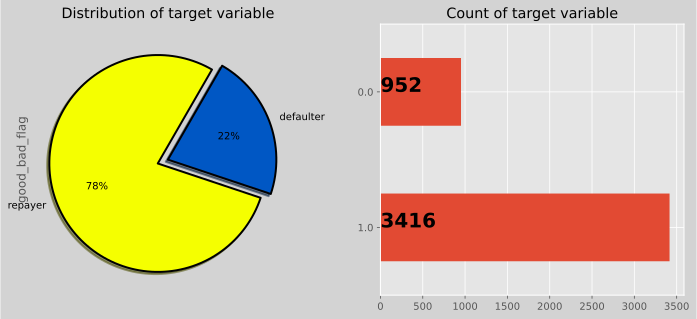

In [12]:
# Distribution of the target variable
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)
Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",7),
                                                                             startangle = 60,
                                            labels=["repayer","defaulter"],wedgeprops={"linewidth":2,"edgecolor":"k"},
                                            explode=[.1,0],shadow =True)
plt.title("Distribution of target variable")

plt.subplot(122)
ax = Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().plot(kind="barh")

for i,j in enumerate(Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize=20)

plt.title("Count of target variable")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")
plt.show()

### 4.3 Missing Values

#### 4.3.1 Percentage of Missing values in performance train and test data

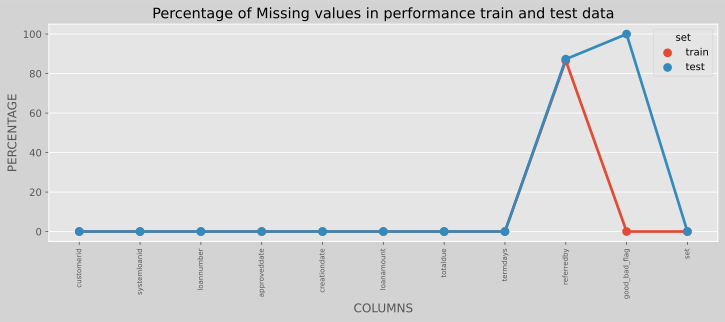

In [13]:
fig = plt.figure(figsize=(12,4))
miss_train = pd.DataFrame((Tperfomance[Tperfomance['set'] == "train"].isnull().sum())*100/Tperfomance[Tperfomance['set'] == "train"].shape[0]).reset_index()
miss_test  = pd.DataFrame((Tperfomance[Tperfomance['set'] == "test"].isnull().sum())*100/Tperfomance[Tperfomance['set'] == "test"].shape[0]).reset_index()
miss_train["set"] = "train"
miss_test["set"]  =  "test"
missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot("index",0,data=missing,hue="set")
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values in performance train and test data")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")

#### 4.3.2 Percentage of Missing values in other data sets

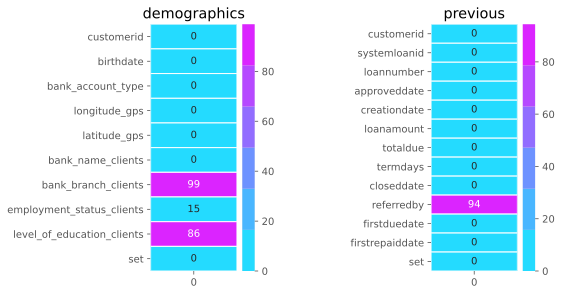

In [14]:
plt.figure(figsize=(12,10))

plt.subplot(231)
sns.heatmap(pd.DataFrame(Tdemographics.isnull().sum()/Tdemographics.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("demographics")

plt.subplot(232)
sns.heatmap(pd.DataFrame(Tprevious.isnull().sum()/Tprevious.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("previous")

plt.subplots_adjust(wspace = 1.6)

### 4.4 Feature Engineering

#### 4.4.1 Tdemographics

In [15]:
Tdemographics.head(3)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,set
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.32,6.53,GT Bank,NaN,NaN,NaN,train
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.33,7.12,Sterling Bank,NaN,Permanent,NaN,train
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.75,5.56,Fidelity Bank,NaN,NaN,NaN,train


In [16]:
Tdemographics.drop_duplicates(subset=Tdemographics.columns,keep='last', inplace=True)

##### 4.4.1.1 Age

In [17]:
Tdemographics['Age']=2018-Tdemographics.birthdate.dt.year

In [18]:
Tdemographics.Age=pd.cut(Tdemographics.Age,[0,13,31,51,100],labels=['ChildAge','YoungAge','MiddleAge','SeniorAge'])

##### 4.4.1.2 bank_account_type (type of primary bank account)

In [19]:
Tdemographics["bank_account_type"].value_counts()

Savings    4570
Other      1168
Current      80
Name: bank_account_type, dtype: int64

In [20]:
Tdemographics["bank_account_type"] = Tdemographics["bank_account_type"].replace("Current", "Other")

In [21]:
Tdemographics["bank_account_type"].value_counts()

Savings    4570
Other      1248
Name: bank_account_type, dtype: int64

In [22]:
pd.crosstab(Tdemographics.employment_status_clients,Tdemographics.bank_account_type,margins=True).style.background_gradient(cmap='summer_r')

bank_account_type,Other,Savings,All
employment_status_clients,,,
Contract,1,1,2
Permanent,813,3392,4205
Retired,2,6,8
Self-Employed,322,148,470
Student,73,116,189
Unemployed,25,54,79
All,1236,3717,4953


##### 4.4.1.3 level_of_education_clients

In [23]:
Tdemographics["level_of_education_clients"].value_counts()

Graduate         576
Secondary        118
Post-Graduate     90
Primary           11
Name: level_of_education_clients, dtype: int64

##### 4.4.1.4 bank_name_clients

In [24]:
Tdemographics["bank_name_clients"].value_counts()

GT Bank               2128
First Bank             790
Access Bank            567
UBA                    461
Zenith Bank            412
Diamond Bank           392
EcoBank                202
Stanbic IBTC           193
FCMB                   168
Skye Bank              146
Fidelity Bank          139
Sterling Bank           67
Wema Bank               37
Union Bank              36
Heritage Bank           27
Keystone Bank           25
Standard Chartered      19
Unity Bank               9
Name: bank_name_clients, dtype: int64

**<font color="red">high cardinality will drop the variable**

##### 4.4.1.5 bank_branch_clients

In [25]:
Tdemographics["bank_branch_clients"].value_counts()

OGBA                  3
APAPA                 3
OBA AKRAN             3
HEAD OFFICE           3
OREGUN                2
                     ..
ADENIRAN OGUNSANYA    1
MEDICAL ROAD IKEJA    1
DUGBE,IBADAN          1
AWOLOWO               1
TINCAN                1
Name: bank_branch_clients, Length: 55, dtype: int64

**<font color="red">high cardinality will drop the variable**

##### 4.4.1.6 employment_status_clients

In [26]:
Tdemographics["employment_status_clients"].value_counts()

Permanent        4205
Self-Employed     470
Student           189
Unemployed         79
Retired             8
Contract            2
Name: employment_status_clients, dtype: int64

#### 4.4.1.7 bank_name_clients

In [27]:
Tdemographics["bank_name_clients"].value_counts()

GT Bank               2128
First Bank             790
Access Bank            567
UBA                    461
Zenith Bank            412
Diamond Bank           392
EcoBank                202
Stanbic IBTC           193
FCMB                   168
Skye Bank              146
Fidelity Bank          139
Sterling Bank           67
Wema Bank               37
Union Bank              36
Heritage Bank           27
Keystone Bank           25
Standard Chartered      19
Unity Bank               9
Name: bank_name_clients, dtype: int64

Characterize this variable with external data, such as liquidity ratios(thanks to HB)

In [28]:
Liquidity_Ratio = pd.read_csv("../data/external/Nigerian_Banks_Liquidity_Ratio_Efficiency_Ratio_and_Profitability.csv", sep=";")

In [29]:
Liquidity_Ratio.head(3)

,S_N,Bank,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset
0,1,First Bank,0.10,0.01,1.12,0.96,0.89,0.08,0.65
1,2,UBA,0.10,0.01,1.04,0.93,0.49,0.33,0.34
2,3,Zenith Bank,0.09,0.03,1.12,0.93,0.64,0.14,0.47


In [30]:
Tdemographics = pd.merge(Tdemographics, Liquidity_Ratio, how = 'left', left_on = 'bank_name_clients', right_on = 'Bank')

In [31]:
Tdemographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818 entries, 0 to 5817
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  5818 non-null   object        
 1   birthdate                   5818 non-null   datetime64[ns]
 2   bank_account_type           5818 non-null   object        
 3   longitude_gps               5818 non-null   float64       
 4   latitude_gps                5818 non-null   float64       
 5   bank_name_clients           5818 non-null   object        
 6   bank_branch_clients         65 non-null     object        
 7   employment_status_clients   4953 non-null   object        
 8   level_of_education_clients  795 non-null    object        
 9   set                         5818 non-null   object        
 10  Age                         5818 non-null   category      
 11  S_N                         5579 non-null   float64     

In [32]:
Tdemographics[Tdemographics["Current_Ratio"].isnull()]["bank_name_clients"].unique()

array(['FCMB', 'Standard Chartered', 'Heritage Bank', 'Keystone Bank'],
      dtype=object)

Yes, these 4 banks do not exist in the Liquidity_Ratio database, we will fill in the missing values ​​later

We take the opportunity to add another table to characterize banks, it's always nice

In [33]:
data_deposit = pd.read_csv("../data/external/Data_25_deposit_commercial_banks_Nigeria_2005.csv", sep=";")

In [34]:
data_deposit.head(3)

,Bank names,Status,Time,Merger,Age,Revenue,Asset
0,Access Bank,0,10,0,26,258.00,"2,590.00"
1,AfribankPlc*,1,7,0,52,0.24,"1,010.00"
2,Diamond Bank,0,10,1,25,6.22,"1,750.00"


In [35]:
Tdemographics = pd.merge(Tdemographics, data_deposit, how = 'left', left_on = 'bank_name_clients', right_on = 'Bank names')
Tdemographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818 entries, 0 to 5817
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  5818 non-null   object        
 1   birthdate                   5818 non-null   datetime64[ns]
 2   bank_account_type           5818 non-null   object        
 3   longitude_gps               5818 non-null   float64       
 4   latitude_gps                5818 non-null   float64       
 5   bank_name_clients           5818 non-null   object        
 6   bank_branch_clients         65 non-null     object        
 7   employment_status_clients   4953 non-null   object        
 8   level_of_education_clients  795 non-null    object        
 9   set                         5818 non-null   object        
 10  Age_x                       5818 non-null   category      
 11  S_N                         5579 non-null   float64     

In [36]:
Tdemographics[Tdemographics["Age_y"].isnull()]["bank_name_clients"].unique()

array(['Stanbic IBTC', 'Heritage Bank', 'Keystone Bank'], dtype=object)

Still these three banks that are missing

In [37]:
Tdemographics.head(3)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,set,Age_x,S_N,Bank,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset,Bank names,Status,Time,Merger,Age_y,Revenue,Asset
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.32,6.53,GT Bank,NaN,NaN,NaN,train,MiddleAge,4.00,GT Bank,0.24,0.04,0.99,0.82,0.71,0.32,0.47,GT Bank,0.00,10.00,0.00,25.00,280.10,"2,520.00"
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.33,7.12,Sterling Bank,NaN,Permanent,NaN,train,MiddleAge,8.00,Sterling Bank,0.16,0.01,0.81,0.74,0.46,0.11,0.36,Sterling Bank,0.00,10.00,1.00,56.00,130.60,799.50
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.75,5.56,Fidelity Bank,NaN,NaN,NaN,train,YoungAge,7.00,Fidelity Bank,0.07,0.01,1.24,0.93,0.79,0.13,0.56,Fidelity Bank,0.00,10.00,0.00,27.00,146.90,"1,232.00"


In [38]:
Tdemographics.drop(columns=['bank_name_clients','bank_branch_clients','birthdate','Bank','Bank names'],axis=1,inplace=True)

---

#### 4.4.2 Tprevious

In [39]:
Tprevious.head(3)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,set
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,"10,000.00","13,000.00",30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43,train
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,"10,000.00","13,000.00",30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00,train
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,"20,000.00","23,800.00",30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47,train


##### 4.4.2.1 Profit

In [40]:
Tprevious['profit']=Tprevious['totaldue']-Tprevious['loanamount']

##### 4.4.2.2 Return Days

In [41]:
Tprevious['return_days']=Tprevious.closeddate-Tprevious.approveddate
Tprevious['return_days']=Tprevious['return_days'].apply(lambda x:int(str(x)[:2]))

##### 4.4.2.3 Days Left

In [42]:
Tprevious['days_left']=Tprevious.termdays-Tprevious.return_days

##### 4.4.2.4 Features Extracted

In [43]:
#Totalprofit
Totalprofit=Tprevious.pivot_table(values='profit',index='customerid',aggfunc=sum)
Totalprofit.rename(columns={'profit':'Totalprofit'},inplace=True)

#Avgprofit
Avgprofit=Tprevious.pivot_table(values='profit',index='customerid',aggfunc=np.mean)
Avgprofit.rename(columns={'profit':'Avgprofit'},inplace=True)

#Avgloanamount
Avgloanamount=Tprevious.pivot_table(values='loanamount',index='customerid',aggfunc=np.mean)
Avgloanamount.rename(columns={'loanamount':'Avgloanamount'},inplace=True)

#Avgtermdays
Avgtermdays=Tprevious.pivot_table(values='termdays',index='customerid',aggfunc=np.mean)
Avgtermdays.rename(columns={'termdays':'Avgtermdays'},inplace=True)

#earlypayment
earlypayment=Tprevious.pivot_table(values='days_left',index='customerid',aggfunc=lambda x:(x>=0).sum())
earlypayment.rename(columns={'days_left':'earlypayment'},inplace=True)

#Avgdaysleft
Avgdaysleft=Tprevious.pivot_table(values='days_left',index='customerid',aggfunc=np.mean)
Avgdaysleft.rename(columns={'days_left':'Avgdaysleft'},inplace=True)

In [44]:
data=[Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment]

In [45]:
data=data[0].join(data[1:])

In [46]:
data.head(3)

,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment
customerid,,,,,,
8a1088a0484472eb01484669e3ce4e0b,"1,500.00","1,500.00","10,000.00",15.00,-7.00,0
8a1a1e7e4f707f8b014f797718316cad,"19,500.00","4,875.00","17,500.00",37.50,6.25,3
8a1a32fc49b632520149c3b8fdf85139,"16,500.00","2,357.14","12,857.14",19.29,1.00,6


---

#### 4.4.3 Tperfomance

In [47]:
Tperfomance.head(3)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,set
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,"30,000.00","34,500.00",30,NaN,1.00,train
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,"15,000.00","17,250.00",30,NaN,1.00,train
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,"20,000.00","22,250.00",15,NaN,1.00,train


##### 4.4.3.1 Profit

In [48]:
Tperfomance['new_profit']=Tperfomance['totaldue']-Tperfomance['loanamount']

In [49]:
Tperfomance.drop(columns=['systemloanid','referredby','creationdate','approveddate','totaldue'],inplace=True)

##### 4.4.3.2. loanamount,loannumber

In [50]:
print('Highest loan amount is:', Tperfomance['loanamount'].max())
print('Lowest loan amount is:', Tperfomance['loanamount'].min())
print('Average loan amount is:', Tperfomance['loanamount'].mean())
print('Median loan amount is:', Tperfomance['loanamount'].median())

Highest loan amount is: 60000.0
Lowest loan amount is: 10000.0
Average loan amount is: 17727.74149192162
Median loan amount is: 10000.0


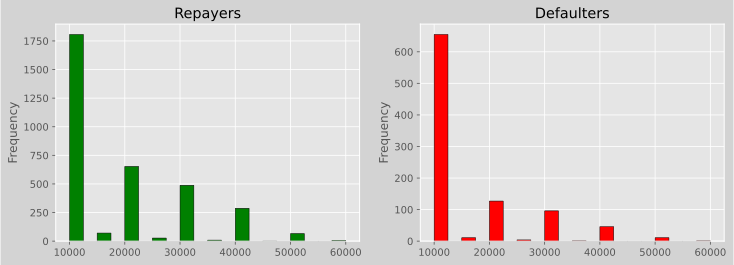

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
Tperfomance[Tperfomance['good_bad_flag'] == 1].loanamount.plot.hist(
    ax=ax[0], bins=20, edgecolor='black', color='green')
ax[0].set_title('Repayers')
Tperfomance[Tperfomance['good_bad_flag'] == 0].loanamount.plot.hist(
    ax=ax[1], color='red', bins=20, edgecolor='black')
ax[1].set_title('Defaulters')
fig.set_facecolor("lightgrey")
plt.show()

In [52]:
print('Highest loan number is:', Tperfomance['loannumber'].max())
print('Lowest loan number is:', Tperfomance['loannumber'].min())
print('Average loan number is:', Tperfomance['loannumber'].mean())
print('Median loan number is:', Tperfomance['loannumber'].median())

Highest loan number is: 34
Lowest loan number is: 2
Average loan number is: 5.151598487452733
Median loan number is: 4.0


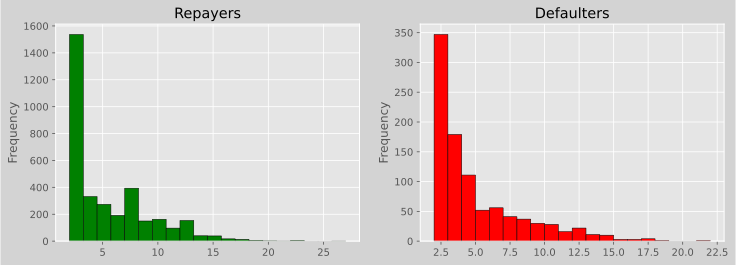

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
Tperfomance[Tperfomance['good_bad_flag'] == 1].loannumber.plot.hist(
    ax=ax[0], bins=20, edgecolor='black', color='green')
ax[0].set_title('Repayers')
Tperfomance[Tperfomance['good_bad_flag'] == 0].loannumber.plot.hist(
    ax=ax[1], color='red', bins=20, edgecolor='black')
ax[1].set_title('Defaulters')
fig.set_facecolor("lightgrey")
plt.show()

#### 4.5 Merge the dataset

In [54]:
#merge data which has attributes from previous loans to performance data
data=pd.merge(data.reset_index(),Tperfomance,how='outer',on='customerid')

##### 4.5.1  Features from merged data

In [55]:
data.head(3)

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,good_bad_flag,set,new_profit
0,8a1088a0484472eb01484669e3ce4e0b,"1,500.00","1,500.00","10,000.00",15.00,-7.00,0.00,2,"10,000.00",15,0.00,train,"1,500.00"
1,8a1a1e7e4f707f8b014f797718316cad,"19,500.00","4,875.00","17,500.00",37.50,6.25,3.00,5,"30,000.00",60,1.00,train,"9,000.00"
2,8a1a32fc49b632520149c3b8fdf85139,"16,500.00","2,357.14","12,857.14",19.29,1.00,6.00,8,"20,000.00",30,1.00,train,"4,500.00"


In [56]:
data['loanamountdeviation']=data.Avgloanamount-data.loanamount
data['profitdeviation']=data.Avgprofit-data.new_profit
data['termdaysdeviation']=data.Avgtermdays-data.termdays

In [57]:
data.head(3)

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,good_bad_flag,set,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation
0,8a1088a0484472eb01484669e3ce4e0b,"1,500.00","1,500.00","10,000.00",15.00,-7.00,0.00,2,"10,000.00",15,0.00,train,"1,500.00",0.00,0.00,0.00
1,8a1a1e7e4f707f8b014f797718316cad,"19,500.00","4,875.00","17,500.00",37.50,6.25,3.00,5,"30,000.00",60,1.00,train,"9,000.00","-12,500.00","-4,125.00",-22.50
2,8a1a32fc49b632520149c3b8fdf85139,"16,500.00","2,357.14","12,857.14",19.29,1.00,6.00,8,"20,000.00",30,1.00,train,"4,500.00","-7,142.86","-2,142.86",-10.71


In [58]:
#merge data which has attributes from previous & performance loans to demographics data
data=pd.merge(data,Tdemographics,on='customerid',how='inner')

In [59]:
data.tail()

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,good_bad_flag,set_x,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,longitude_gps,latitude_gps,employment_status_clients,level_of_education_clients,set_y,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset,Status,Time,Merger,Age_y,Revenue,Asset
5813,8a8589005384ab570153880ceba74594,nan,nan,nan,nan,nan,nan,3,"30,000.00",60,nan,test,"9,000.00",nan,nan,nan,Other,3.42,6.44,Permanent,Graduate,train,MiddleAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.47,0.00,10.00,0.00,25.00,280.10,"2,520.00"
5814,8a858f2d5853901a01585c79a6021b8f,nan,nan,nan,nan,nan,nan,2,"30,000.00",60,nan,test,"9,000.00",nan,nan,nan,Savings,3.31,6.51,Permanent,Graduate,test,MiddleAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.47,0.00,10.00,0.00,25.00,280.10,"2,520.00"
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,nan,nan,nan,2,"20,000.00",30,nan,test,"3,000.00",nan,nan,nan,Savings,3.36,6.64,Permanent,Graduate,train,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.34,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,nan,nan,nan,2,"10,000.00",15,nan,test,"1,500.00",nan,nan,nan,Savings,3.31,6.64,Permanent,Graduate,train,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.47,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,nan,nan,nan,3,"20,000.00",30,nan,test,"4,500.00",nan,nan,nan,Savings,3.37,6.64,Permanent,Graduate,train,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.47,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [60]:
data.drop(columns=['set_x','set_y'],inplace=True)

In [61]:
data.shape

(5818, 35)

**<font color="red">really dont know how to use longitude and latitude. i will drop it, if you manage to make good use of it , share with me the results**

In [62]:
cols=[x for x in data.columns if x not in ['longitude_gps','latitude_gps']]
data=data[cols]

In [63]:
#export the data
data.to_csv('../data/interim/feature_matrix.csv', index=False)

---

## 5. Feature Selection

### 5.1 Correlation

In [64]:
#calculate corelations
correlation =  data.corr()
correlation.to_csv('../data/interim/correlations_spec.csv')

In [65]:
correlations = pd.read_csv('../data/interim/correlations_spec.csv', index_col =0)
correlations.index.name = 'Variable'
correlations.head()

,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset,Status,Time,Merger,Age_y,Revenue,Asset
Variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Totalprofit,1.00,0.66,0.92,0.43,0.18,0.90,0.94,0.86,0.53,0.09,0.53,-0.71,-0.24,-0.32,-0.02,0.00,-0.01,0.00,0.00,0.02,0.02,0.01,-0.00,nan,0.01,0.00,-0.03,0.00
Avgprofit,0.66,1.00,0.61,0.93,0.22,0.47,0.46,0.54,0.60,0.05,0.55,-0.43,-0.06,-0.05,-0.01,-0.00,-0.01,0.00,-0.00,-0.00,0.02,-0.01,-0.00,nan,0.01,-0.01,-0.03,-0.02
Avgloanamount,0.92,0.61,1.00,0.33,0.21,0.86,0.85,0.89,0.48,0.10,0.50,-0.70,-0.23,-0.33,-0.01,0.00,-0.01,0.01,0.01,0.03,0.01,0.02,-0.00,nan,0.00,0.01,-0.03,0.01
Avgtermdays,0.43,0.93,0.33,1.00,0.19,0.23,0.22,0.29,0.53,0.02,0.41,-0.23,0.07,0.08,0.00,-0.00,-0.02,-0.00,-0.00,-0.02,0.02,-0.02,-0.00,nan,0.01,-0.02,-0.03,-0.03
Avgdaysleft,0.18,0.22,0.21,0.19,1.00,0.29,0.12,0.23,0.20,0.24,0.17,-0.22,-0.07,-0.10,-0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.00,-0.01,nan,0.01,0.00,-0.03,0.01


In [66]:
#correlation with target
correlations_target = correlations.sort_values('good_bad_flag')['good_bad_flag']
# Most negative correlations
correlations_target.head(5)

Variable
loanamountdeviation   -0.11
Revenue               -0.03
Return_On_Equity      -0.02
Age_y                 -0.01
profitdeviation       -0.01
Name: good_bad_flag, dtype: float64

In [67]:
# Most positive correlations
correlations_target.dropna().tail(5)

Variable
Avgloanamount   0.10
loanamount      0.12
earlypayment    0.15
Avgdaysleft     0.24
good_bad_flag   1.00
Name: good_bad_flag, dtype: float64

##### Visualize Distribution of Correlated Variables

In [68]:
features_sample = pd.read_csv('../data/interim/feature_matrix.csv')
features_sample['good_bad_flag'] = features_sample['good_bad_flag'].fillna(-1).astype(int)
features_sample.head(3)

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset,Status,Time,Merger,Age_y,Revenue,Asset
0,8a1088a0484472eb01484669e3ce4e0b,"1,500.00","1,500.00","10,000.00",15.00,-7.00,0.00,2,"10,000.00",15,0,"1,500.00",0.00,0.00,0.00,Savings,Permanent,Primary,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.47,0.00,10.00,0.00,25.00,280.10,"2,520.00"
1,8a1a1e7e4f707f8b014f797718316cad,"19,500.00","4,875.00","17,500.00",37.50,6.25,3.00,5,"30,000.00",60,1,"9,000.00","-12,500.00","-4,125.00",-22.50,Other,Permanent,Graduate,MiddleAge,nan,nan,nan,nan,nan,nan,nan,nan,0.00,10.00,1.00,16.00,2.10,12.00
2,8a1a32fc49b632520149c3b8fdf85139,"16,500.00","2,357.14","12,857.14",19.29,1.00,6.00,8,"20,000.00",30,1,"4,500.00","-7,142.86","-2,142.86",-10.71,Savings,Permanent,Graduate,MiddleAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.47,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [69]:
def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['good_bad_flag'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['good_bad_flag'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); 
    plt.ylabel('Density');
    plt.show()

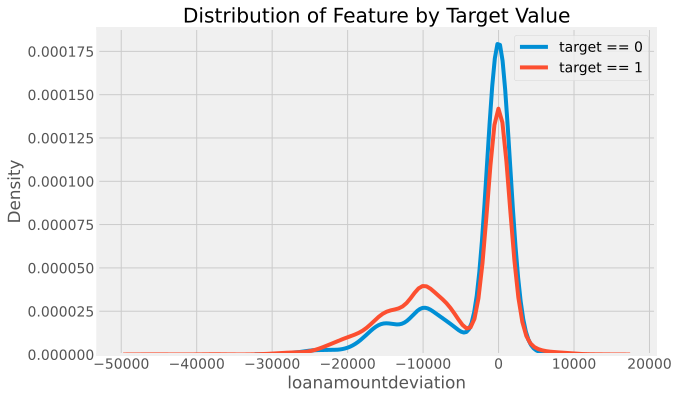

In [70]:
kde_target_plot(features_sample, feature = 'loanamountdeviation')

##### collinear features

In [71]:
threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in correlations:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [72]:
correlated_pairs['Avgloanamount']

['Totalprofit']

In [73]:
correlations['Avgloanamount'].sort_values(ascending=False).head()

Variable
Avgloanamount   1.00
Totalprofit     0.92
loanamount      0.89
earlypayment    0.86
loannumber      0.85
Name: Avgloanamount, dtype: float64

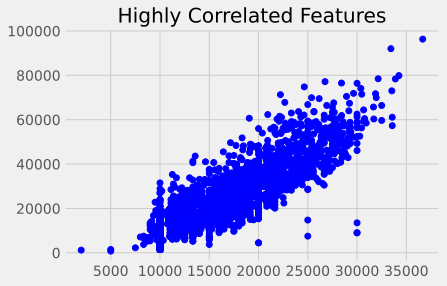

In [74]:
plt.plot(features_sample['Avgloanamount'], features_sample['Totalprofit'], 'bo')
plt.title('Highly Correlated Features');

##### drop correlated features

In [75]:
# Upper triangle of correlations
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
upper.head()

,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset,Status,Time,Merger,Age_y,Revenue,Asset
Variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Totalprofit,nan,0.66,0.92,0.43,0.18,0.90,0.94,0.86,0.53,0.09,0.53,-0.71,-0.24,-0.32,-0.02,0.00,-0.01,0.00,0.00,0.02,0.02,0.01,-0.00,nan,0.01,0.00,-0.03,0.00
Avgprofit,nan,nan,0.61,0.93,0.22,0.47,0.46,0.54,0.60,0.05,0.55,-0.43,-0.06,-0.05,-0.01,-0.00,-0.01,0.00,-0.00,-0.00,0.02,-0.01,-0.00,nan,0.01,-0.01,-0.03,-0.02
Avgloanamount,nan,nan,nan,0.33,0.21,0.86,0.85,0.89,0.48,0.10,0.50,-0.70,-0.23,-0.33,-0.01,0.00,-0.01,0.01,0.01,0.03,0.01,0.02,-0.00,nan,0.00,0.01,-0.03,0.01
Avgtermdays,nan,nan,nan,nan,0.19,0.23,0.22,0.29,0.53,0.02,0.41,-0.23,0.07,0.08,0.00,-0.00,-0.02,-0.00,-0.00,-0.02,0.02,-0.02,-0.00,nan,0.01,-0.02,-0.03,-0.03
Avgdaysleft,nan,nan,nan,nan,nan,0.29,0.12,0.23,0.20,0.24,0.17,-0.22,-0.07,-0.10,-0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.00,-0.01,nan,0.01,0.00,-0.03,0.01


In [76]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 5 columns to remove.


In [77]:
to_drop

['Avgloanamount', 'Avgtermdays', 'earlypayment', 'loannumber', 'Loan_to_Asset']

In [78]:
#columns to drop
features_sample = features_sample.drop(columns = to_drop)
print('data shape: ', features_sample.shape)

data shape:  (5818, 28)


### 5.2 Feature Selection through Feature Importances

We will use a Gradient Boosted Model from the LightGBM library to assess feature importances. 

Since the LightGBM model does not need missing values to be imputed, we can directly fit on the training data. We will use Early Stopping to determine the optimal number of iterations and run the model twice, averaging the feature importances to try and avoid overfitting to a certain set of features.

In [79]:
features_sample.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,"20,000.00",30,-1,"3,000.00",nan,nan,nan,Savings,Permanent,Graduate,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,"10,000.00",15,-1,"1,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,"20,000.00",30,-1,"4,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [80]:
feature_sample2 = features_sample.copy(deep=True)

In [81]:
feature_sample2.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,"20,000.00",30,-1,"3,000.00",nan,nan,nan,Savings,Permanent,Graduate,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,"10,000.00",15,-1,"1,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,"20,000.00",30,-1,"4,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00"


**dummify the variables**

In [82]:
feature_sample2.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,"20,000.00",30,-1,"3,000.00",nan,nan,nan,Savings,Permanent,Graduate,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,"10,000.00",15,-1,"1,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,"20,000.00",30,-1,"4,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [83]:
#Dummify the variables
feature_sample2 = pd.get_dummies(feature_sample2, columns=['bank_account_type', 'employment_status_clients','level_of_education_clients',
                                                           'Age_x'], drop_first=True, prefix=['bank_account_type', 
                                                                                              'employment_status_clients',
                                                                                              'level_of_education_clients','Age_x'])

In [84]:
feature_sample2.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,"20,000.00",30,-1,"3,000.00",nan,nan,nan,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00",1,1,0,0,0,0,0,0,0,0,0
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,"10,000.00",15,-1,"1,500.00",nan,nan,nan,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",1,1,0,0,0,0,0,0,0,0,1
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,"20,000.00",30,-1,"4,500.00",nan,nan,nan,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,0,0,0,1


In [85]:
train=feature_sample2[(feature_sample2['good_bad_flag'] == 1) | (feature_sample2['good_bad_flag'] == 0)]

In [86]:
test=feature_sample2[feature_sample2['good_bad_flag'] < 0]

In [87]:
print(train.shape)
print(test.shape)

(4368, 35)
(1450, 35)


In [88]:
display(train.head(3))
display(test.head(3))

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
0,8a1088a0484472eb01484669e3ce4e0b,"1,500.00","1,500.00",-7.00,"10,000.00",15,0,"1,500.00",0.00,0.00,0.00,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,1,0,0,1
1,8a1a1e7e4f707f8b014f797718316cad,"19,500.00","4,875.00",6.25,"30,000.00",60,1,"9,000.00","-12,500.00","-4,125.00",-22.50,nan,nan,nan,nan,nan,nan,nan,0.00,10.00,1.00,16.00,2.10,12.00,0,1,0,0,0,0,0,0,0,0,0
2,8a1a32fc49b632520149c3b8fdf85139,"16,500.00","2,357.14",1.00,"20,000.00",30,1,"4,500.00","-7,142.86","-2,142.86",-10.71,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,0,0,0,0


,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
6,8a28afc7474813a40147639ec637156b,"32,900.00","3,290.00",6.00,"25,000.00",30,-1,"2,500.00","-7,200.00",790.00,1.50,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",0,1,0,0,0,0,0,0,0,0,0
12,8a3735d5518aba7301518ac34413010d,"18,000.00","3,000.00",13.33,"20,000.00",30,-1,"4,500.00","-8,333.33","-1,500.00",-2.50,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",0,1,0,0,0,0,0,0,0,0,0
18,8a76e7d443e6e97c0143ed099d102b1d,"3,000.00","1,500.00",1.50,"20,000.00",30,-1,"4,500.00","-10,000.00","-3,000.00",-15.00,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",0,1,0,0,0,0,0,0,0,0,0


In [89]:
#rename good_bad
train.rename(columns={'good_bad_flag': 'TARGET'}, inplace=True)
test.rename(columns={'good_bad_flag': 'TARGET'}, inplace=True)

In [90]:
#drop traget column in test
test.drop('TARGET', axis=1, inplace=True)

In [91]:
print(train.shape)
print(test.shape)

(4368, 35)
(1450, 34)


In [92]:
train_labels = train['TARGET']
train_ids = train['customerid']
test_ids = test['customerid']

In [93]:
#remove the customerid
columns = ['customerid']
test.drop(columns, inplace=True, axis=1)
train.drop(columns, inplace=True, axis=1)

In [94]:
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (4368, 34)
Testing shape:  (1450, 33)


**<font color="red">We align the dataframes by the columns. This ensures we have the same columns in the training and testing datasets.**

In [95]:
#We align the dataframes by the columns. This ensures we have the same columns in the training and testing datasets
#Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (4368, 33)
Testing shape:  (1450, 33)


In [96]:
display(train.head(3))
display(test.head(3))

,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
0,"1,500.00","1,500.00",-7.00,"10,000.00",15,"1,500.00",0.00,0.00,0.00,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,1,0,0,1
1,"19,500.00","4,875.00",6.25,"30,000.00",60,"9,000.00","-12,500.00","-4,125.00",-22.50,nan,nan,nan,nan,nan,nan,nan,0.00,10.00,1.00,16.00,2.10,12.00,0,1,0,0,0,0,0,0,0,0,0
2,"16,500.00","2,357.14",1.00,"20,000.00",30,"4,500.00","-7,142.86","-2,142.86",-10.71,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,0,0,0,0


,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
6,"32,900.00","3,290.00",6.00,"25,000.00",30,"2,500.00","-7,200.00",790.00,1.50,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",0,1,0,0,0,0,0,0,0,0,0
12,"18,000.00","3,000.00",13.33,"20,000.00",30,"4,500.00","-8,333.33","-1,500.00",-2.50,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",0,1,0,0,0,0,0,0,0,0,0
18,"3,000.00","1,500.00",1.50,"20,000.00",30,"4,500.00","-10,000.00","-3,000.00",-15.00,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",0,1,0,0,0,0,0,0,0,0,0


#### 5.3.1 Feature Importance

In [97]:
# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [98]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [99]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.3, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.684458	valid_0's binary_logloss: 0.614845
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.66722	valid_0's binary_logloss: 0.622891


In [100]:
# Make sure to average feature importances! 
x = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 
                                    'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
2,Avgdaysleft,150.00
0,Totalprofit,74.00
7,profitdeviation,55.00
1,Avgprofit,51.00
6,loanamountdeviation,42.00


In [101]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 9 features with 0.0 importance


,feature,importance
28,level_of_education_clients_Post-Graduate,0.00
29,level_of_education_clients_Primary,0.00
17,Time,0.00
31,Age_x_SeniorAge,0.00
16,Status,0.00


It looks like many of the features we made have literally 0 importance. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we can remove these features from the model with no effect on performance.

In [102]:
def plot_feature_importances(df, threshold = 0.9):
    
    plt.rcParams['font.size'] = 14
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (10, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

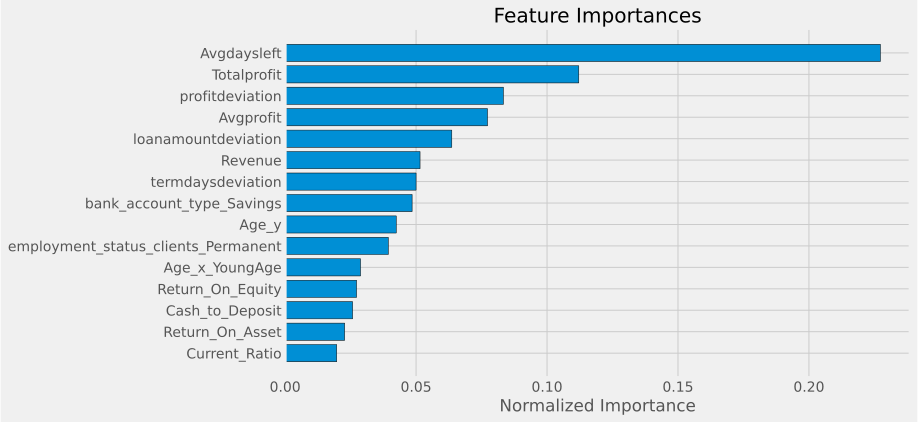

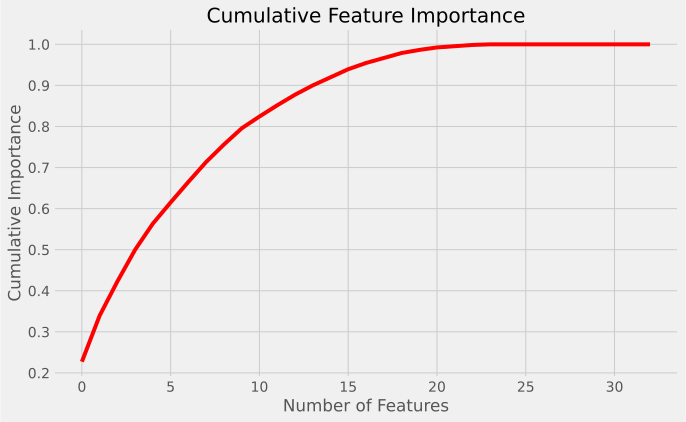

15 features required for 0.90 of cumulative importance


In [103]:
norm_feature_importances = plot_feature_importances(feature_importances)

Let's remove the features that have zero importance.

In [104]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (4368, 24)
Testing shape:  (1450, 24)


At this point, we can re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our own form of recursive feature elimination. 

In [105]:
def identify_zero_importance_features(train, train_labels, iterations = 2):

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000,class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):
        
        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [106]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	valid_0's auc: 0.681268	valid_0's binary_logloss: 0.618089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.699211	valid_0's binary_logloss: 0.622921

There are 2 features with 0.0 importance


Now, there are no 0 importance features left. If we want to remove more features, we will create a threshold percentage of importance, such as 95%, to remove less important features.

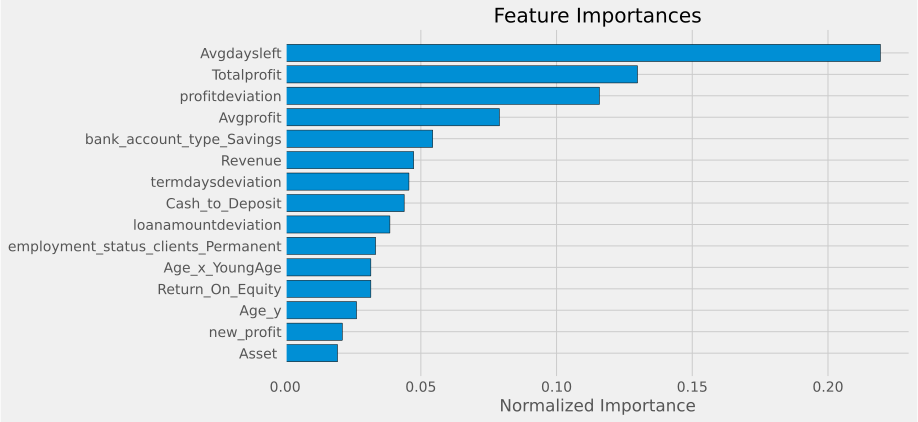

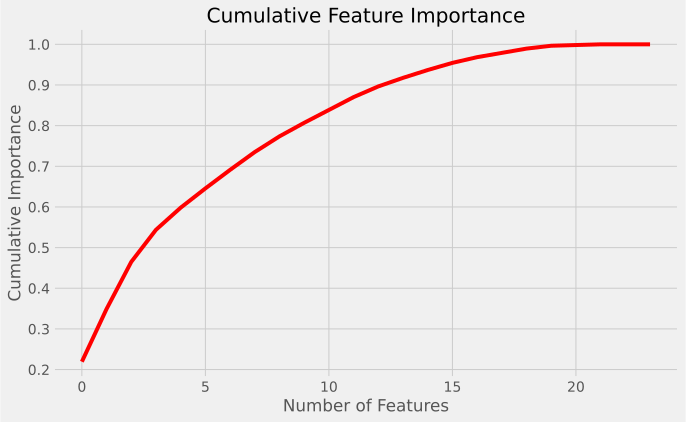

16 features required for 0.95 of cumulative importance


In [107]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

We can keep only the features needed for 95% importance. 

Then, we can test both versions of the data to see if the extra feature removal step is worthwhile.

In [108]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [109]:
train_small['TARGET'] = train_labels
train_small['customerid'] = train_ids
test_small['customerid'] = test_ids

train_small.to_csv('../data/interim/m_train_small.csv', index = False)
test_small.to_csv('../data/interim/m_test_small.csv', index = False)

---

## 6.0 MODELLING

In [110]:
# Some sklearn tools for preprocessing and building a pipeline. 
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [111]:
features_sample.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,"20,000.00",30,-1,"3,000.00",nan,nan,nan,Savings,Permanent,Graduate,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,"10,000.00",15,-1,"1,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,"20,000.00",30,-1,"4,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [112]:
features_sample_final = features_sample.copy(deep=True)

In [113]:
#Dummify the variables
# Encoding categorical variables
# create three dummy variables using get_dummies, then exclude the first dummy column
def dummify(col_name, df):
    df_dummies = pd.get_dummies(df[col_name], prefix=col_name).iloc[:, 1:] 
    return df_dummies 

In [114]:
#call the function
dummy_cols = ['bank_account_type','employment_status_clients','level_of_education_clients','Age_x']
for col_name in dummy_cols:
    dummies = dummify(col_name, features_sample_final)
    features_sample_final = pd.concat([features_sample_final, dummies], axis=1) # join the dummy columns to the original df
    features_sample_final = features_sample_final.drop([col_name], axis=1) # drop the original cat. vars column

In [115]:
features_sample_final.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,"20,000.00",30,-1,"3,000.00",nan,nan,nan,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00",1,1,0,0,0,0,0,0,0,0,0
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,"10,000.00",15,-1,"1,500.00",nan,nan,nan,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",1,1,0,0,0,0,0,0,0,0,1
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,"20,000.00",30,-1,"4,500.00",nan,nan,nan,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,0,0,0,1


In [116]:
#rename good_bad
features_sample_final.rename(columns={'good_bad_flag': 'TARGET'}, inplace=True)

In [117]:
features_sample_final.fillna(0, inplace=True)

In [118]:
features_sample_final.isnull().sum()

customerid                                  0
Totalprofit                                 0
Avgprofit                                   0
Avgdaysleft                                 0
loanamount                                  0
                                           ..
level_of_education_clients_Post-Graduate    0
level_of_education_clients_Primary          0
level_of_education_clients_Secondary        0
Age_x_SeniorAge                             0
Age_x_YoungAge                              0
Length: 35, dtype: int64

In [119]:
features_sample_final.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,TARGET,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
5815,8a858e9f59d692440159da2c60b42106,0.00,0.00,0.00,"20,000.00",30,-1,"3,000.00",0.00,0.00,0.00,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00",1,1,0,0,0,0,0,0,0,0,0
5816,8a858f0d58a18ebc0158a9bf124b5a30,0.00,0.00,0.00,"10,000.00",15,-1,"1,500.00",0.00,0.00,0.00,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",1,1,0,0,0,0,0,0,0,0,1
5817,8a85890253e2f1180153eae33e5e6bc3,0.00,0.00,0.00,"20,000.00",30,-1,"4,500.00",0.00,0.00,0.00,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,0,0,0,1


In [120]:
train=features_sample_final[(features_sample_final['TARGET'] == 1) | (features_sample_final['TARGET'] == 0)]

In [121]:
test=features_sample_final[features_sample_final['TARGET'] < 0]

In [122]:
X = train.drop(["customerid", "TARGET"], axis=1)
print("Train Set Shape: {} Rows, {} Columns".format(*X.shape))
test = test.drop(["TARGET"], axis=1)
print("Submission Set Shape: {} Rows, {} Columns".format(*test.shape))
#y = train["TARGET"].values
y = train["TARGET"]

Train Set Shape: 4368 Rows, 33 Columns
Submission Set Shape: 1450 Rows, 34 Columns


In [123]:
X.head(3)

,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
0,"1,500.00","1,500.00",-7.00,"10,000.00",15,"1,500.00",0.00,0.00,0.00,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,1,0,0,1
1,"19,500.00","4,875.00",6.25,"30,000.00",60,"9,000.00","-12,500.00","-4,125.00",-22.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,1.00,16.00,2.10,12.00,0,1,0,0,0,0,0,0,0,0,0
2,"16,500.00","2,357.14",1.00,"20,000.00",30,"4,500.00","-7,142.86","-2,142.86",-10.71,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,0,0,0,0


In [124]:
y

0       0
1       1
2       1
3       1
4       1
       ..
5805    1
5806    1
5807    0
5808    1
5809    1
Name: TARGET, Length: 4368, dtype: int64

In [125]:
#split the train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

### Function to measure the model

In [126]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,roc_auc_score,classification_report,roc_auc_score,roc_curve,auc

#Model function
def model(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):

    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    print (algorithm)
    
    print ("Accuracy score : ", accuracy_score(predictions,dtest_Y))
    print ("Recall score   : ", recall_score(predictions,dtest_Y))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    
    fig = plt.figure(figsize=(10,8))
    ax  = fig.add_subplot(111)
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE & AREA UNDER CURVE")
    #ax.set_facecolor("k")


#### LogisticRegression

LogisticRegression()
Accuracy score :  0.7803203661327232
Recall score   :  0.782375478927203
classification report :
               precision    recall  f1-score   support

           0       0.01      0.33      0.01         6
           1       1.00      0.78      0.88      1305

    accuracy                           0.78      1311
   macro avg       0.50      0.56      0.45      1311
weighted avg       0.99      0.78      0.87      1311



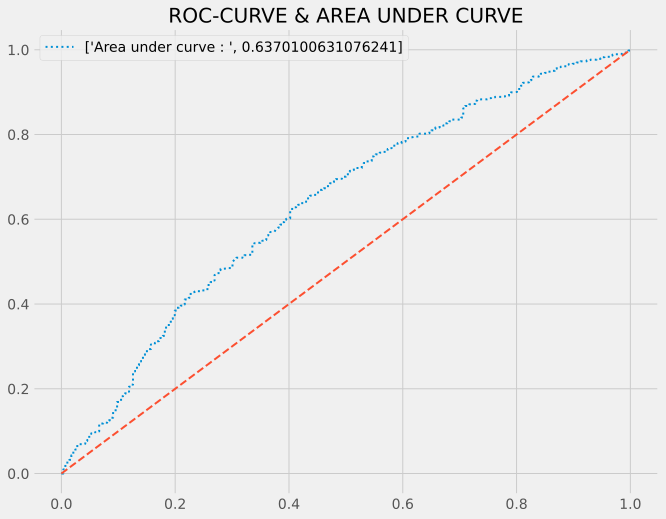

In [127]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
model(logit,X_train,y_train,X_test,y_test,X_train.columns)

#### Random Forest Classifier

RandomForestClassifier()
Accuracy score :  0.7574370709382151
Recall score   :  0.8131089459698848
classification report :
               precision    recall  f1-score   support

           0       0.26      0.41      0.32       182
           1       0.90      0.81      0.85      1129

    accuracy                           0.76      1311
   macro avg       0.58      0.61      0.59      1311
weighted avg       0.81      0.76      0.78      1311



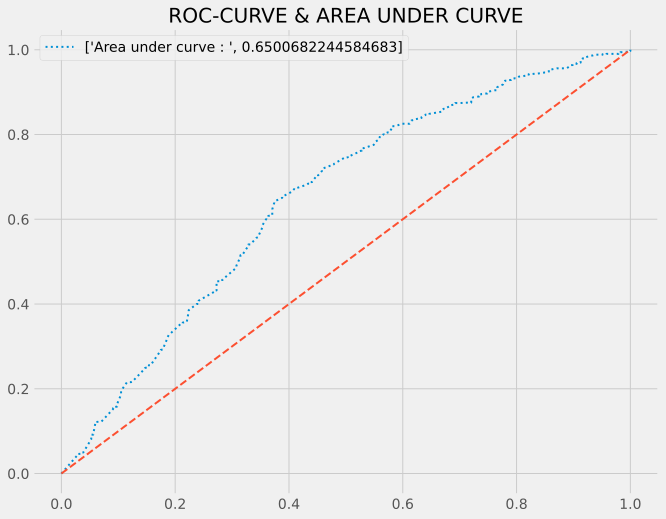

In [128]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
model(rfc,X_train,y_train,X_test,y_test,X_train.columns)

#### Decision Tree Classifier

DecisionTreeClassifier()
Accuracy score :  0.6826849733028223
Recall score   :  0.8110316649642493
classification report :
               precision    recall  f1-score   support

           0       0.35      0.30      0.33       332
           1       0.77      0.81      0.79       979

    accuracy                           0.68      1311
   macro avg       0.56      0.56      0.56      1311
weighted avg       0.67      0.68      0.67      1311



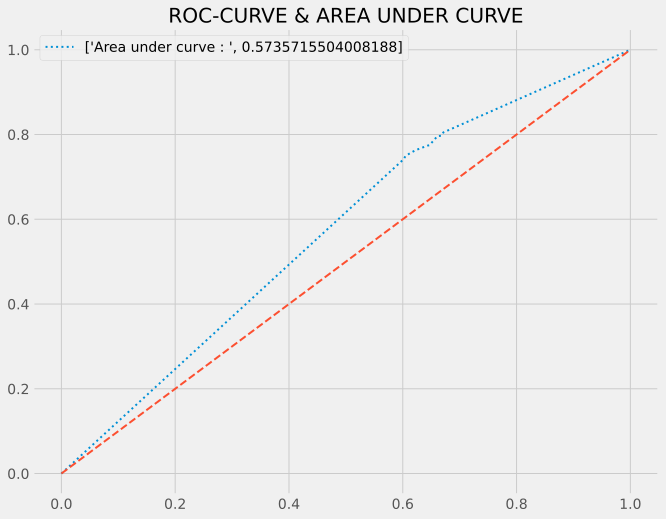

In [129]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
model(dtc,X_train,y_train,X_test,y_test,X_train.columns)

#### Gaussian Naive Bayes

GaussianNB()
Accuracy score :  0.6971777269260107
Recall score   :  0.8390928725701944
classification report :
               precision    recall  f1-score   support

           0       0.48      0.36      0.41       385
           1       0.76      0.84      0.80       926

    accuracy                           0.70      1311
   macro avg       0.62      0.60      0.60      1311
weighted avg       0.68      0.70      0.68      1311



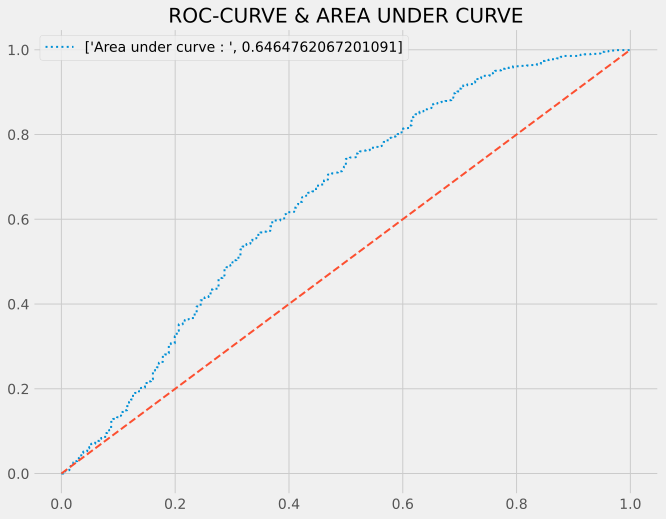

In [130]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model(gnb,X_train,y_train,X_test,y_test,X_train.columns)

#### XGBoost Classifier

[15:34:56] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy score :  0.7604881769641495
Recall score   :  0.8062015503875969
classification report :
               pre

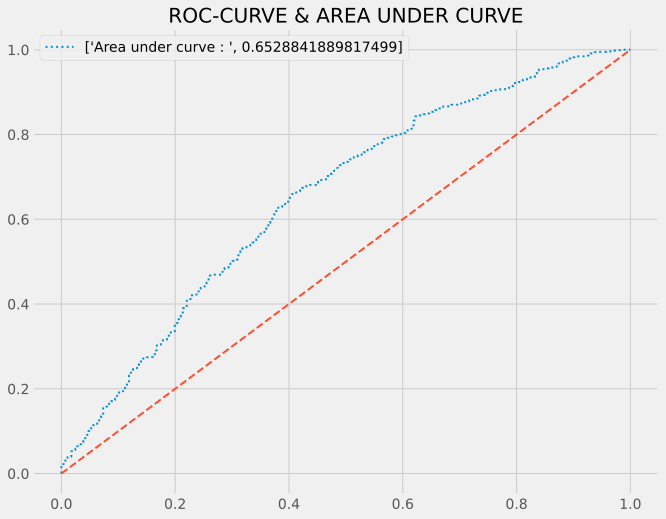

In [131]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
model(xgb,X_train,y_train,X_test,y_test,X_train.columns)

#### Gradient Boosting Classifier

GradientBoostingClassifier()
Accuracy score :  0.7909992372234935
Recall score   :  0.8105872622001654
classification report :
               precision    recall  f1-score   support

           0       0.20      0.56      0.29       102
           1       0.96      0.81      0.88      1209

    accuracy                           0.79      1311
   macro avg       0.58      0.68      0.59      1311
weighted avg       0.90      0.79      0.83      1311



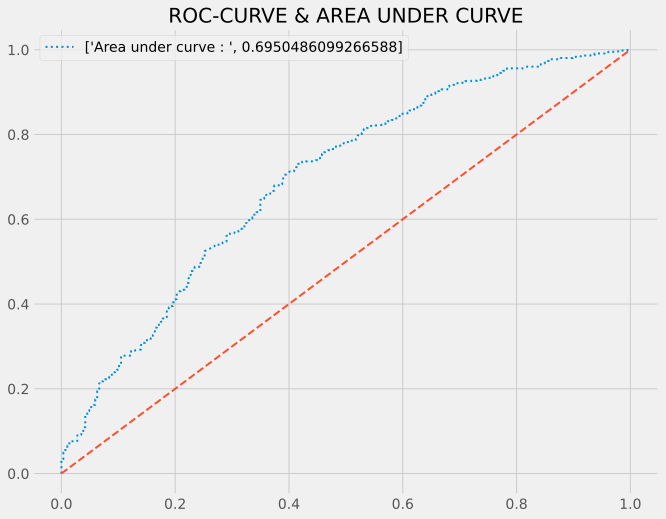

In [132]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model(gbc,X_train,y_train,X_test,y_test,X_train.columns)

**<font color="red">Best model is GradientBoostingClassifier with an AUC of 0.69 but in terms of accuracy it's Logistic regression with accuracy of 0.78**

---

#### use new libraries like yellowbrick to explain the models

In [133]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport

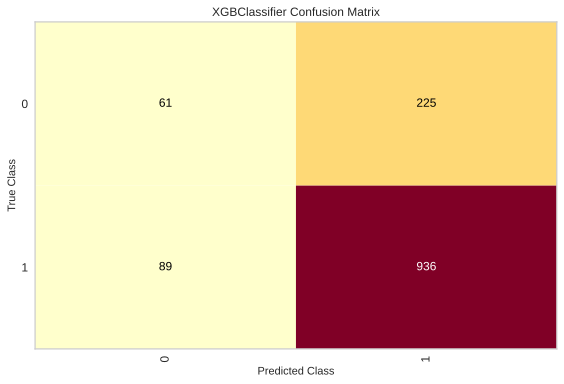

In [134]:
fig, ax = plt.subplots()
cm = ConfusionMatrix(xgb, classes=[0, 1], ax=ax)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test, y_test)

#How did we do?
cm.poof()

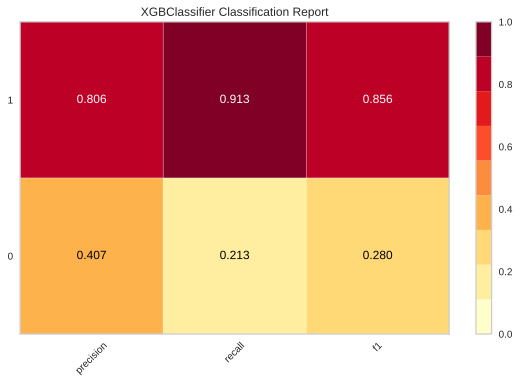

In [135]:
fig, ax = plt.subplots()
visualizer = ClassificationReport(xgb, classes=[0, 1], ax=ax)
ax.grid(False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

---

#### Create submission file

In [136]:
test_sub_X = test[[i for i in test.columns if i not in ['customerid']]]
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
sub_prob = gbc.predict_proba(test_sub_X)[:,1]
sub_prob = pd.DataFrame(sub_prob)
ids = test[["customerid"]]
subm  = ids.merge(sub_prob,left_index=True,right_index=True,how="left")
sample_submission  = subm.rename(columns={"customerid":'customerid',0:'Good_Bad_flag'})

In [137]:
sample_submission.head()

,customerid,Good_Bad_flag
6,8a28afc7474813a40147639ec637156b,0.89
12,8a3735d5518aba7301518ac34413010d,0.65
18,8a76e7d443e6e97c0143ed099d102b1d,0.60
21,8a818823525dceef01525deda2480384,0.82
23,8a818926522ea5ef01523aff15c37482,0.86


In [138]:
sample_submission.to_csv("best_model.csv",index = False)

## Deployment

In [139]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

iface = gr.Interface(
  fn=greet, 
  inputs=gr.inputs.Textbox(lines=2, placeholder="Name Here..."), 
  outputs="text")
iface.launch()

Running locally at: http://127.0.0.1:7860/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7860/', None)

---